In [85]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore');
plt.rcParams.update({'figure.max_open_warning': 0})
import scipy.stats as stats
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join
from tqdm import tqdm
from bisect import bisect_left
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
plt.rcParams.update({'font.size': 22})
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
plt.rcParams['figure.figsize'] = [15, 10]
from IPython.display import Audio, display
def allDone():
    display(Audio(filename='beep.mp3', autoplay=True))
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
import lmfit

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
import emcee
from lmfit import Model,Minimizer
import corner
import numdifftools
from scipy.ndimage.interpolation import shift
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from multiprocessing import Pool
import pickle

In [86]:
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,scale,MinMaxScaler,StandardScaler
import multiprocessing

In [87]:
wdtable = Table.read('wdtable.fits')

In [88]:
inputPath = "../scratch/spec/"
filenames = os.listdir(inputPath)

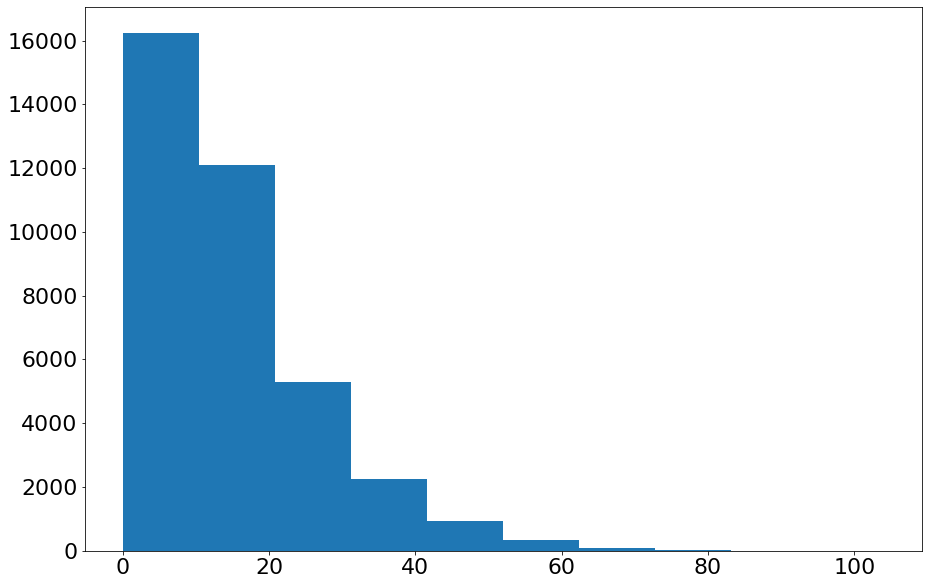

In [89]:
plt.hist(wdtable['S/N']);

In [90]:
wdtable = wdtable[wdtable['spectral_class'] == 'DA']
wdtable = wdtable[ (wdtable['S/N'] > 15) * (wdtable['Teff'] < 50000)]


In [91]:
nonan = ~np.isnan(wdtable['Teff'])*~np.isnan(wdtable['log_g'])
wdtable = wdtable[nonan]

In [92]:
TeffHs = [];
loggHs = [];
specnames = []
spectra = [];

if os.path.exists(inputPath+".DS_Store"):
    os.remove(inputPath+"/.DS_Store")
import pandas as pd
searches = pd.DataFrame(list(wdtable['source_id']))
searches = np.asarray(searches.drop_duplicates())[:,0]

filenames = [str(i)+'_spec_0.fits' for i in searches][0:25]

for specname in tqdm(filenames):
    try:
        f = fits.open(inputPath+specname)
        loglam = f[1].data['loglam']
        flux = f[1].data['flux']
        lam = 10**loglam
        lam = lam.astype(np.float64)
        flux = flux.astype(np.float64)
        lamgrid = np.arange(4000,8000)
        func = interp1d(lam,flux,kind='cubic',assume_sorted = False,fill_value='extrapolate')
        flux = func(lamgrid)
        spectra.append(flux)
        TeffHs.append(wdtable[wdtable['source_id']==int(specname[:-12])]['Teff'][0])
        loggHs.append(wdtable[wdtable['source_id']==int(specname[:-12])]['log_g'][0])
        specnames.append(specname)
    except:
        continue;


spectra = np.asarray(spectra)
TeffHs = np.asarray(TeffHs)
loggHs = np.asarray(loggHs)


100%|██████████| 25/25 [00:02<00:00, 10.53it/s]

25


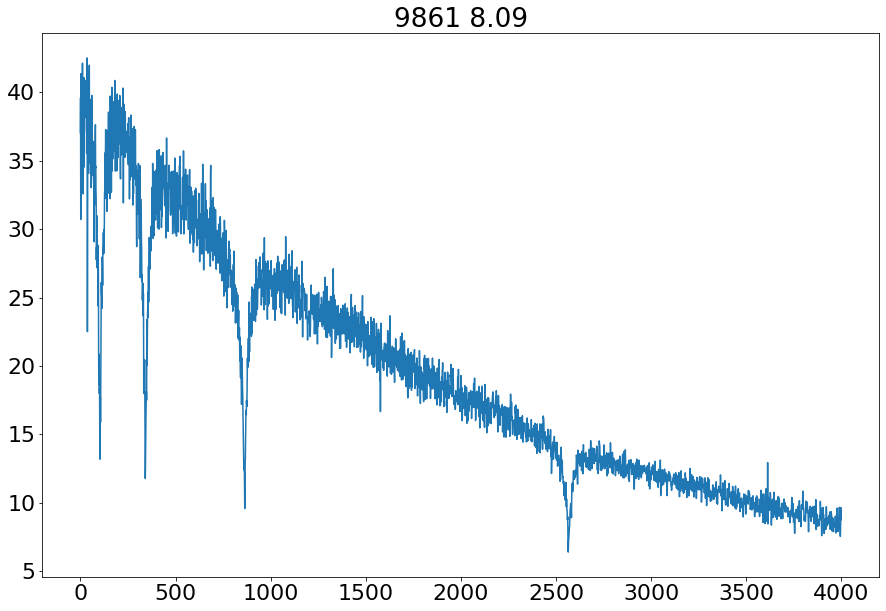

In [93]:
i = np.random.randint(len(spectra))
plt.plot(spectra[i])
plt.title('%i %.2f'%(TeffHs[i],loggHs[i]));
print(len(spectra))

In [102]:
arr = pickle.load(open('modelspecs.p','rb'))
modelspectra = arr[0]
teffs = arr[2]
loggs = arr[1]
lam = np.arange(4000,8000)
lines = ((lam > hbeta-300) & (lam < hbeta + 300)) | ((lam > halpha-400) & (lam < halpha + 400))\
        | ((lam > hgamma-400) & (lam < hgamma + 200))

mask = ~lines | ((lam > 4000) & (lam < 4050)) | ((lam > 4160) & (lam < 4280))

# mask = ((lam < 4700) | (lam > 5000)) & ((lam < 4200) | (lam > 4100)) & ((lam < 6400) | (lam > 6900))
modelspectra = modelspectra.transpose()
from sklearn.preprocessing import MinMaxScaler
lilmask = (lam > 5100)&(lam<5500)
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
sc.fit(modelspectra)

sclabel = MinMaxScaler()
sclabel.fit(np.stack((teffs,loggs)).transpose())

def v_mse(y_true, y_pred):
    return K.mean((1e5*(y_pred) - 1e5*(y_true) )**2)

def v_perc(y_true,y_pred):
    return K.mean( (K.abs(y_pred-y_true)*100/(K.max(y_true))) )

def labelscaler(array):
#     array[:,0] = (array[:,0] - np.min(teffs)) / (np.max(teffs) - np.min(teffs))
#     array[:,1] = (array[:,1] - np.min(loggs)) / (np.max(loggs) - np.min(loggs))
    return sclabel.transform(array)

def labelunscaler(array):
#     array[:,0] = array[:,0] * 80000
#     array[:,1] = array[:,1] * 9.5
    return sclabel.inverse_transform(array)

def modelscaler(array):
    #return ( array - np.min(modelspectra) ) / ( np.max(modelspectra) - np.min(modelspectra) )
    return sc.transform(array)
    
def modelunscaler(array):
    #return (array * ( np.max(modelspectra) - np.min(modelspectra) )) + np.min(modelspectra)
    return sc.inverse_transform(array)

def gen_sampler(wl,t,l,scale,trans):
    pred = shift(np.ravel(\
                          model.predict(labelscaler(np.asarray([t,l]).reshape(1, -1))))[mask],trans,cval=np.nan)
    return scale*pred


def linear(lam,c1,c2):
    return c1 + c2*lam

def signal2noise(flux):
    ## RETURNS S/N ratio
    p,c = curve_fit(linear,lam[lilmask],flux[lilmask])
    return 1/np.sqrt(sum((flux[lilmask] - linear(lam[lilmask],p[0],p[1]))**2)/len(flux[lilmask])/np.mean(flux[lilmask]))

def fluxsig(flux):
    ## RETURNS STD DEV SIGMA
    p,c = curve_fit(linear,lam[lilmask],flux[lilmask])
    return np.sqrt(sum((flux[lilmask] - linear(lam[lilmask],p[0],p[1]))**2) / len(flux[lilmask]))

def continuum_gen_sampler(wl,t,l,scale,trans):
    spec = np.ravel(modelscaling*model.predict(labelscaler(np.asarray([t,l]).reshape(1, -1))))
    p,cov = curve_fit(quadratic,lam[mask],spec[mask],p0=[1,1e-2,1e-5,1e-10])
    contcorr=spec/quadratic(lam,p[0],p[1],p[2],p[3]);
    return shift(contcorr[lines],trans,cval=np.nan)*scale


def quadratic(array,c1,c2,c3,c4):
    return c1 + c2*array + c3*array**2 + c4*array**3

# plt.plot((continuum_gen_sampler(None,12000,6.5,1)))
# plt.plot((continuum_gen_sampler(None,12000,7.,1)))
# plt.plot((continuum_gen_sampler(None,12000,8.,1)))
# plt.plot((continuum_gen_sampler(None,12000,9.,1)))
# plt.plot((continuum_gen_sampler(None,12000,9.5,1)))

def residual(params):
    t = params['t'].value
    l = params['l'].value
    scale = params['scale'].value
    trans = params['trans'].value
    where = ~np.isnan(gen_sampler(None,t,l,scale,trans))
    return (spectra[i][where] - gen_sampler(None,t,l,scale,trans)[where])

def chisquare(residual):
    return sum(residual**2) / (fluxsig(spectra[i])**2 * (len(residual) - len(params)))

def v_mse(y_true, y_pred):
    return K.mean((1e5*y_pred - 1e5*y_true )**2)

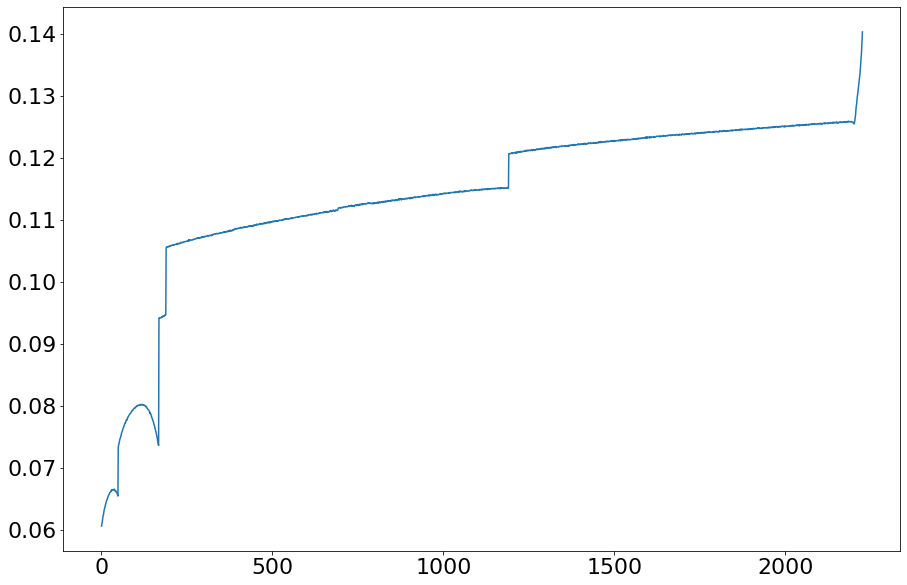

In [103]:
plt.plot(gen_sampler(None,15000,9.,1,0))

In [96]:
from keras import Model
def generator():
    x = Input(shape=(2,))
    y = Dense(128,activation='sigmoid')(x)
    y = Dense(128,activation='sigmoid')(y)
    out = Dense(4000,activation='linear')(y)
    
    model = Model(inputs = x, outputs = out)
    model.compile(optimizer = Adamax(lr=0.05), loss = 'mse', \
                  metrics = ['mean_absolute_percentage_error'])
    return model
model = generator()
model.load_weights('unscaled_gen.h5')

In [97]:
sel1 = 0
sel2 = 25

teffpredictions = [];
teffreal = [];
sigmas = [];
contteffsigs = [];

fitter = lmfit.Model(gen_sampler)
params = lmfit.Parameters()
params.add('t',min=5000,max=80000,value=13000)
params.add('l',min=6.5,max=9.5,value=8.)
params.add('scale',min=0.1,max=5,value=1)
params.add('trans',min=-5,max=5,value=0)
params['l'].set(value = 8.,vary=False)
params['trans'].set(value = 0,vary=True)
contchis = [];

for i in tqdm(range(len(spectra[sel1:sel2]))):
    
    result = fitter.fit(spectra[i][mask],params,wl=lamgrid[mask],method='powell',nan_policy='omit')

    #result = lmfit.minimize(residual,params,nan_policy = 'omit',reduce_fcn=chisquare,method='powell',tol=1e-2)
    
    tpred = result.params['t'].value
    teffpredictions.append(tpred)
    teffreal.append(TeffHs[i])
    contteffsigs.append(result.params['t'].stderr)
    chi = chisquare(result.residual)
    contchis.append(chi)
    
#     plt.figure()
#     plt.plot(spectra[i][mask],'k.')
#     plt.plot(gen_sampler(None,result.params['t'],result.params['l'],result.params['scale'],result.params['trans']),'r.')
#     plt.title('T = %i K, $\chi^2 = %.2f$'%(tpred,chi))
#     plt.show()

#     plt.savefig('plots/generative_fits/full'+str(i)+'.png')
#     plt.close()
teffpredictions = np.asarray(teffpredictions)
teffreal = np.asarray(teffreal)
contteffsigs = np.asarray(contteffsigs)
contchis = np.asarray(contchis)

np.sqrt(sum((teffreal-teffpredictions)**2)/len(teffreal))


100%|██████████| 25/25 [00:11<00:00,  2.18it/s]

64182.802719142

In [83]:
loggpredictions = [];
loggreal = [];
lineteffs = [];
loggsigs = [];
lineteffsigs = [];
linechis =[];
lam = np.arange(4000,8000)
mask = ((lam < 4700) | (lam > 5000)) & ((lam > 4500)) & ((lam < 6400) | (lam > 6900))

loggfitter = lmfit.Model(continuum_gen_sampler)
loggparams = loggfitter.make_params(t = 10000,l=8.,scale=1,trans=0)
loggparams['t'].set(min=5000,max=80000)
loggparams['l'].set(min=6.5,max=9.5)
loggparams['scale'].set(min=0.1,max=5)
loggparams['trans'].set(min=-5,max=5)
loggparams['scale'].set(value=1,vary=False)

for i in tqdm(range(len(spectra[sel1:sel2]))):
    
    p,cov = curve_fit(quadratic,lam[mask],spectra[i][mask],p0=[-25,1e-2,1e-5,1e-10])
    contcorr = (spectra[i]/quadratic(lam,p[0],p[1],p[2],p[3]))
    loggparams['t'].set(value=teffpredictions[i],vary=True) 
#     result = loggfitter.fit(contcorr[lines],loggparams,wl=lam[lines],method='emcee',nan_policy='omit',\
#                         fit_kws = {'steps':500,'nwalkers':100,'workers':1,'burn':100,'is_weighted':False})

    result = loggfitter.fit(contcorr[lines],loggparams,wl=lam[lines],method='powell',nan_policy='omit')
        
    lpred = result.params['l'].value
    tpred2 = result.params['t'].value
    linechis.append(chisquare(result.residual))
    
#     plt.figure(figsize=(10,7))
#     plt.title('%i K, %.2f dex'%(result.params['t'],result.params['l']))
#     plt.plot(lam[lines],contcorr[lines],'k.')
#     plt.plot(lam[lines],continuum_gen_sampler(None,teffpredictions[i],lpred,1,result.params['trans']),'r.')
#     plt.ylabel('Normalized Flux')
#     plt.xlabel('Wavelength(A)')
#     plt.tight_layout()
#     plt.savefig('corner/'+str(i)+'_fit.png')
#     plt.close()
    
#     f,axs = plt.subplots(2,2,figsize=(10,10))
#     corner.corner(result.flatchain[['t','l']], bins = 15,smooth = 1, range = ((tpred2-5000,tpred2+5000),(6.5,9.5)),\
#                  labels = ['$T_{eff}$','$\log{g}$'],fig=f,truths=[teffs[i],loggs[i]])
#     plt.savefig('corner/'+str(i)+'.pdf')
#     plt.close()
    
    loggpredictions.append(lpred)
    loggreal.append(loggHs[i])
    lineteffs.append(tpred2)
    loggsigs.append(result.params['l'].stderr)
    lineteffsigs.append(result.params['t'].stderr)
lineteffs = np.asarray(lineteffs)
teffpredictions = np.asarray(teffpredictions)
loggpredictions = np.asarray(loggpredictions)
loggreal = np.asarray(loggreal)
teffreal = np.asarray(teffreal)
loggsigs = np.asarray(loggsigs)
lineteffsigs = np.asarray(lineteffsigs)


  4%|▍         | 1/25 [00:04<01:48,  4.51s/it]

KeyboardInterrupt: 

RMSE: 64182.803
Error < 1000 Kelvin: 0.00 percent of the time.


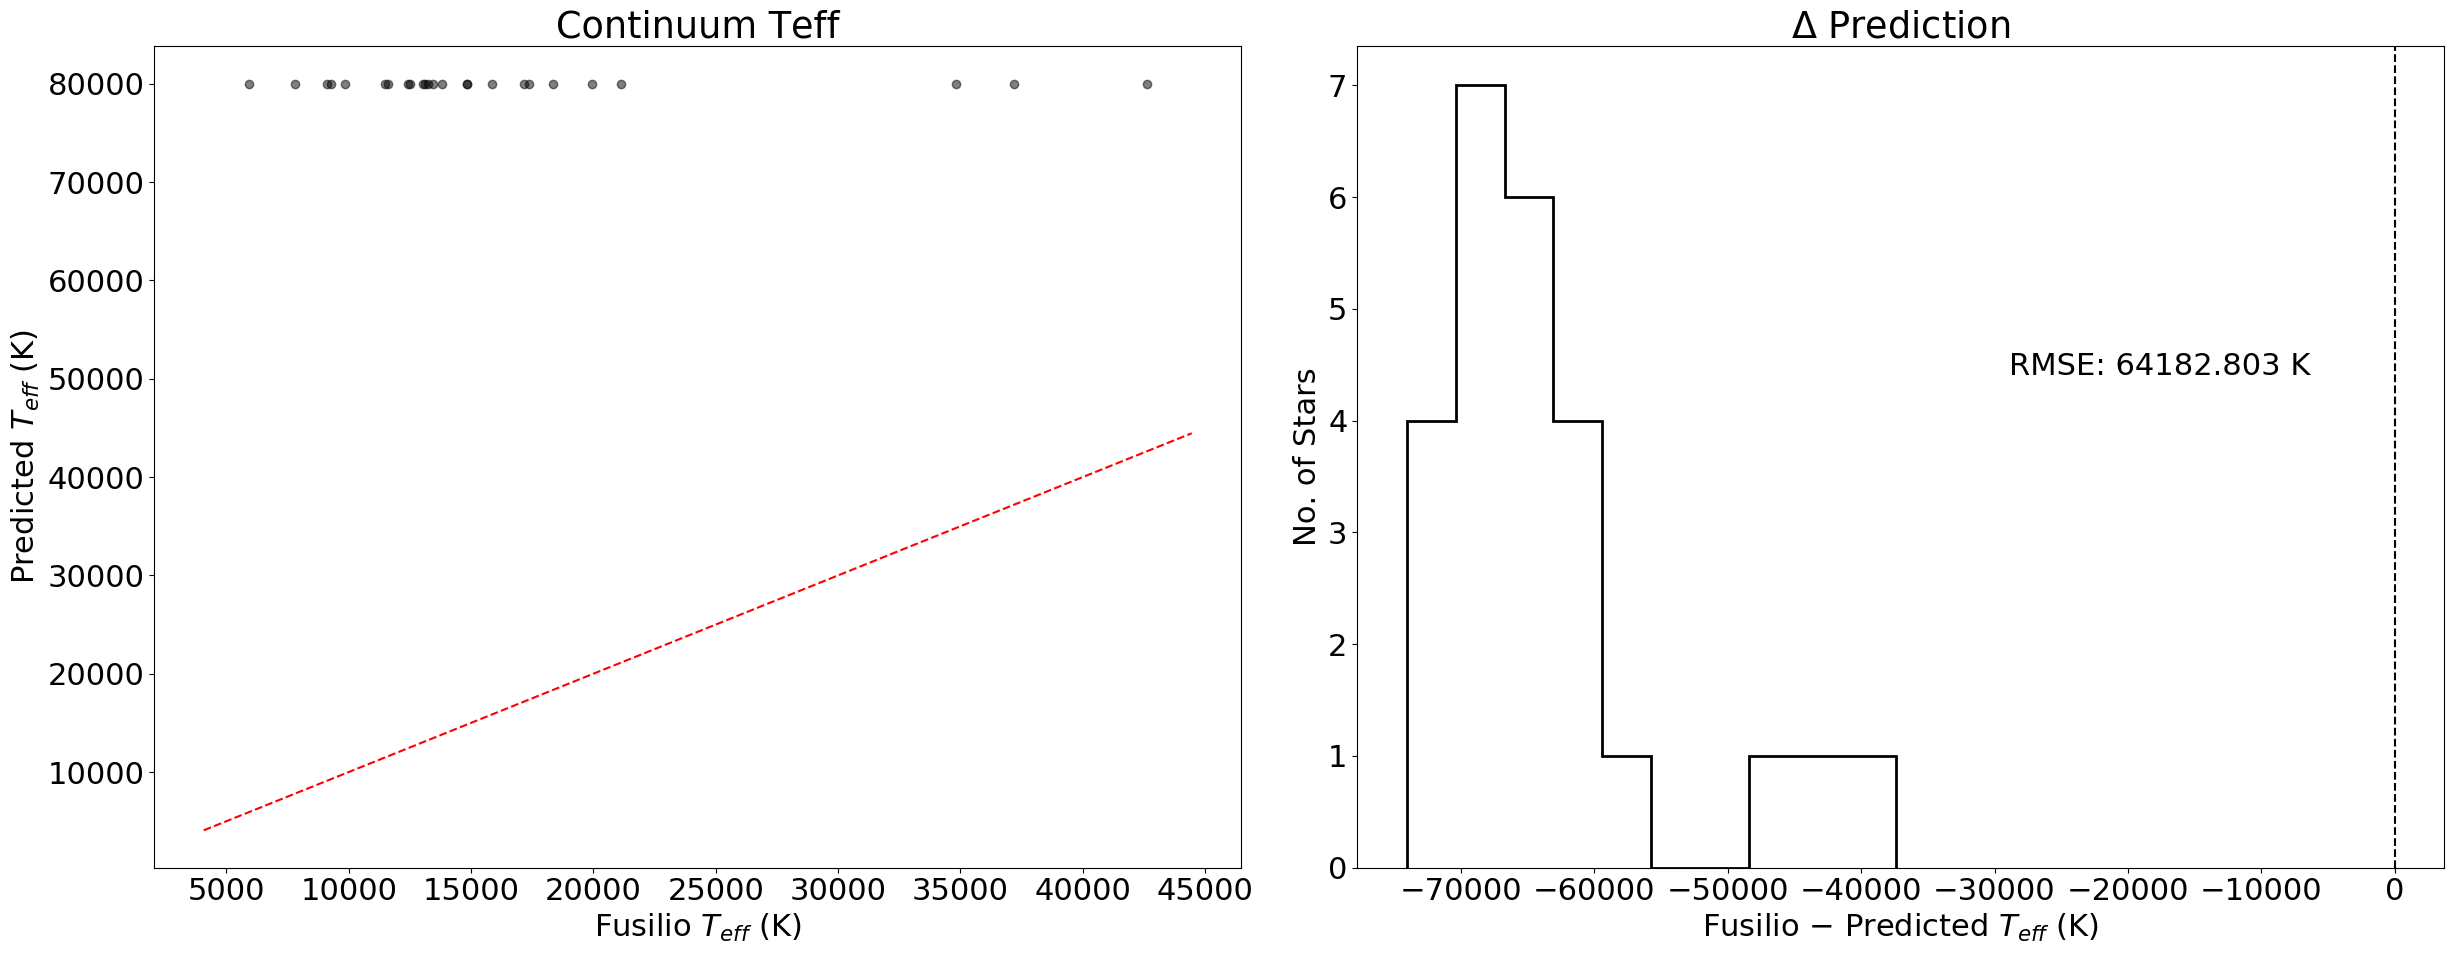

In [84]:
chimask = np.asarray(contchis) < 55000

plt.style.use('default')
plt.rcParams.update({'font.size': 22})
predictions = teffpredictions[chimask]
y_test = teffreal[chimask]
RMSE = np.sqrt( sum(((y_test-predictions)**2)) / (len(y_test)))
plt.figure(figsize=(25,10))
f=plt.subplot(121)
# plt.scatter(y_test,predictions,c=np.asarray(contchis)[chimask],cmap='jet',s=50,alpha=0.7,vmax = 5)
# cbar = plt.colorbar()
plt.errorbar(y_test,predictions,yerr=3*contteffsigs[chimask],linestyle="None",ecolor='k', zorder=1,marker = '.'\
                    ,markeredgecolor='k',markersize=12,alpha=0.5,mfc='k')
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')

plt.xlabel('Fusilio $T_{eff}$ (K)')
plt.ylabel('Predicted $T_{eff}$ (K)')
plt.title('Continuum Teff')
#plt.ylim(1000,50000)

ax = plt.subplot(122)

plt.hist(y_test-predictions,bins=10,histtype='step',color='k',linewidth = 2);
plt.axvline(x=0,color='k',linestyle='--')
plt.title('$\Delta$ Prediction')
plt.xlabel('Fusilio $-$ Predicted $T_{eff}$ (K)')
plt.ylabel('No. of Stars');
plt.text(0.6,0.6,'RMSE: %.3f K'%RMSE,transform=ax.transAxes)
plt.tight_layout()

print('RMSE: %.3f'%RMSE)

print('Error < 1000 Kelvin: %.2f percent of the time.'\
%(100-(sum(abs(y_test-predictions)>1000))*100/len(y_test)))

RMSE: 24004.686
Error < 1000 Kelvin: 0.00 percent of the time.


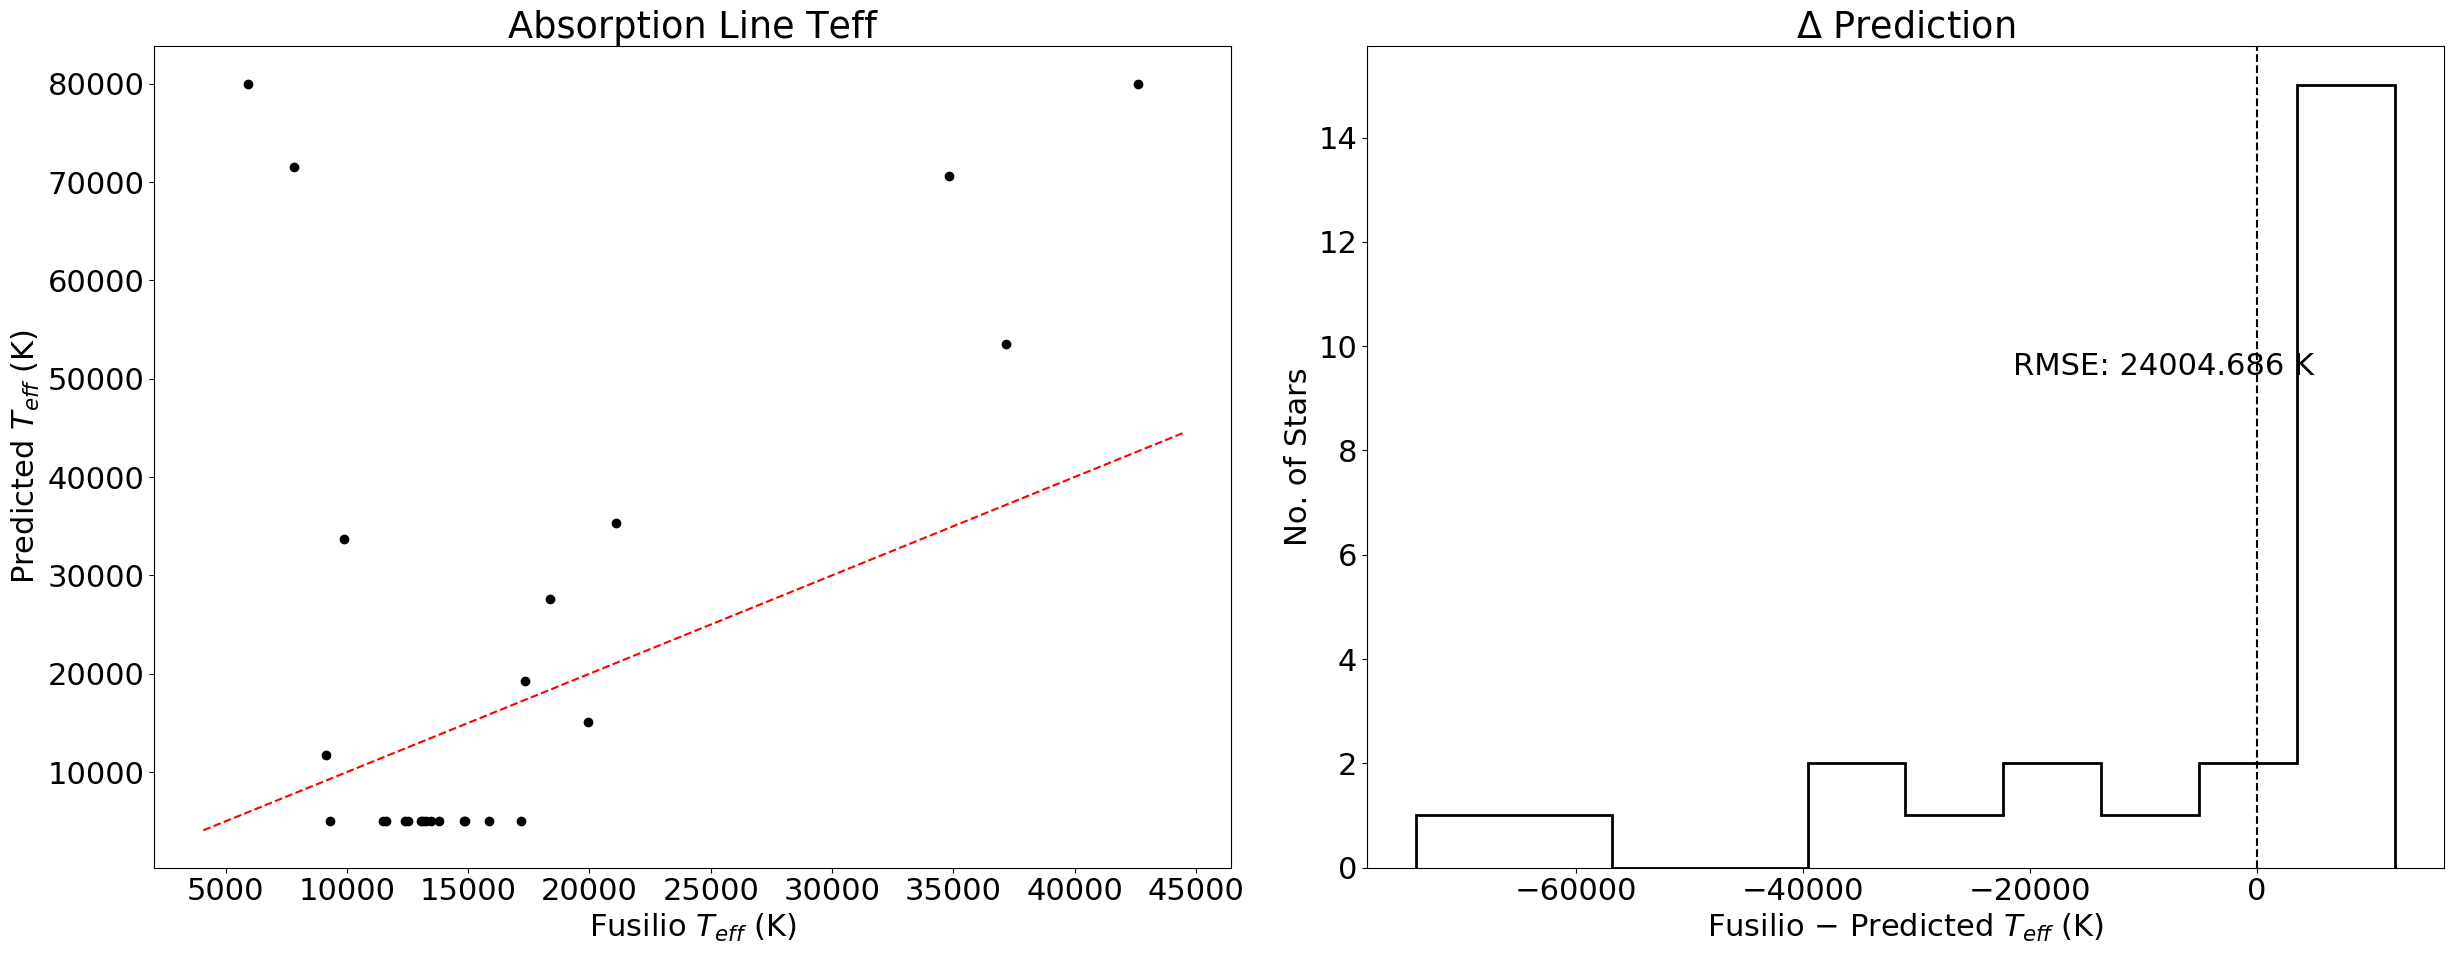

In [37]:
predictions = lineteffs
y_test = teffreal
RMSE = np.sqrt( sum(((y_test-predictions)**2)) / (len(y_test)))
plt.figure(figsize=(25,10))
f=plt.subplot(121)
#plt.errorbar(y_test,predictions,yerr=3*lineteffsigs,linestyle="None",ecolor='k', zorder=1,marker = '.'\
#                     ,markeredgecolor='k',markersize=12,alpha=0.5,mfc='k')
plt.scatter(y_test,predictions,color='k')
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.xlabel('Fusilio $T_{eff}$ (K)')
plt.ylabel('Predicted $T_{eff}$ (K)')
plt.title('Absorption Line Teff')
#plt.ylim(1000,50000)
ax = plt.subplot(122)

plt.hist(y_test-predictions,bins=10,histtype='step',color='k',linewidth = 2);
plt.axvline(x=0,color='k',linestyle='--')
plt.title('$\Delta$ Prediction')
plt.xlabel('Fusilio $-$ Predicted $T_{eff}$ (K)')
plt.ylabel('No. of Stars');
plt.text(0.6,0.6,'RMSE: %.3f K'%RMSE,transform=ax.transAxes)
plt.tight_layout()

print('RMSE: %.3f'%RMSE)

print('Error < 1000 Kelvin: %.2f percent of the time.'\
%(100-(sum(abs(y_test-predictions)>1000))*100/len(y_test)))

RMSE: 1.075


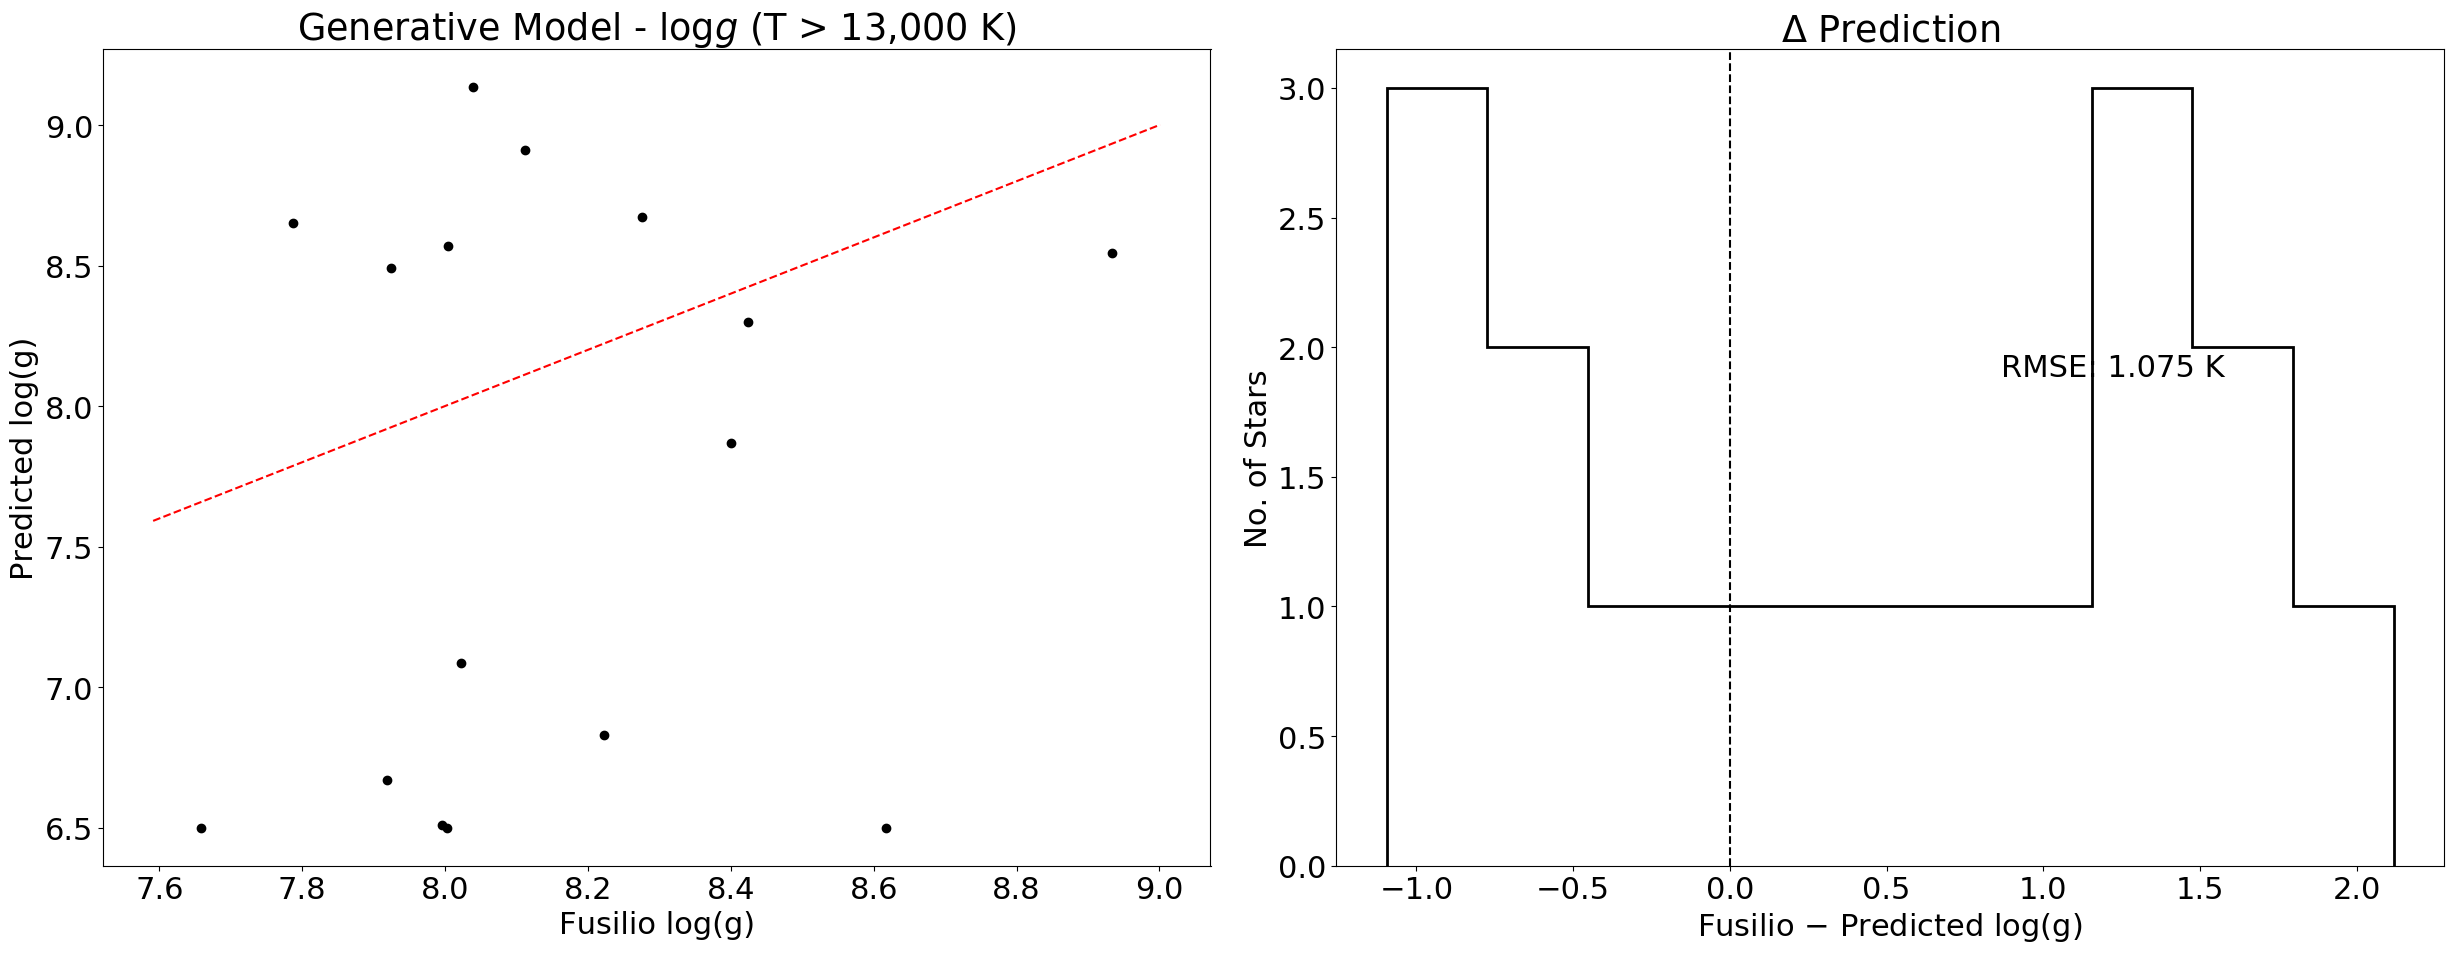

In [38]:
linechis = np.asarray(linechis)
tmask = teffreal > 13000
#tmask=np.repeat(True,len(teffreal))
predictions = loggpredictions[tmask]
y_test = loggreal[tmask]
RMSE = np.sqrt( sum(((y_test-predictions)**2)) / (len(y_test)))
plt.figure(figsize=(25,10))
f=plt.subplot(121)
plt.scatter(y_test,predictions,color='k')
#plt.colorbar()
#plt.errorbar(y_test,predictions,yerr=3*loggsigs[tmask],linestyle="None",ecolor='k', zorder=1,marker = '.'\
 #                    ,markeredgecolor='k',markersize=12,alpha=0.5,mfc='k')
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.xlabel('Fusilio log(g)')
plt.ylabel('Predicted log(g)')
plt.title('Generative Model - $\log{g}$ (T > 13,000 K)')
ax = plt.subplot(122)


plt.hist(y_test-predictions,bins=10,histtype='step',color='k',linewidth = 2);
plt.axvline(x=0,color='k',linestyle='--')
plt.title('$\Delta$ Prediction')
plt.xlabel('Fusilio $-$ Predicted log(g)')
plt.ylabel('No. of Stars');
plt.text(0.6,0.6,'RMSE: %.3f K'%RMSE,transform=ax.transAxes)
plt.tight_layout()

print('RMSE: %.3f'%RMSE)
plt.rcParams.update({'font.size': 22})

# Chi Plots

RMSE: 10593.582
Error < 1000 Kelvin: 25.75 percent of the time.


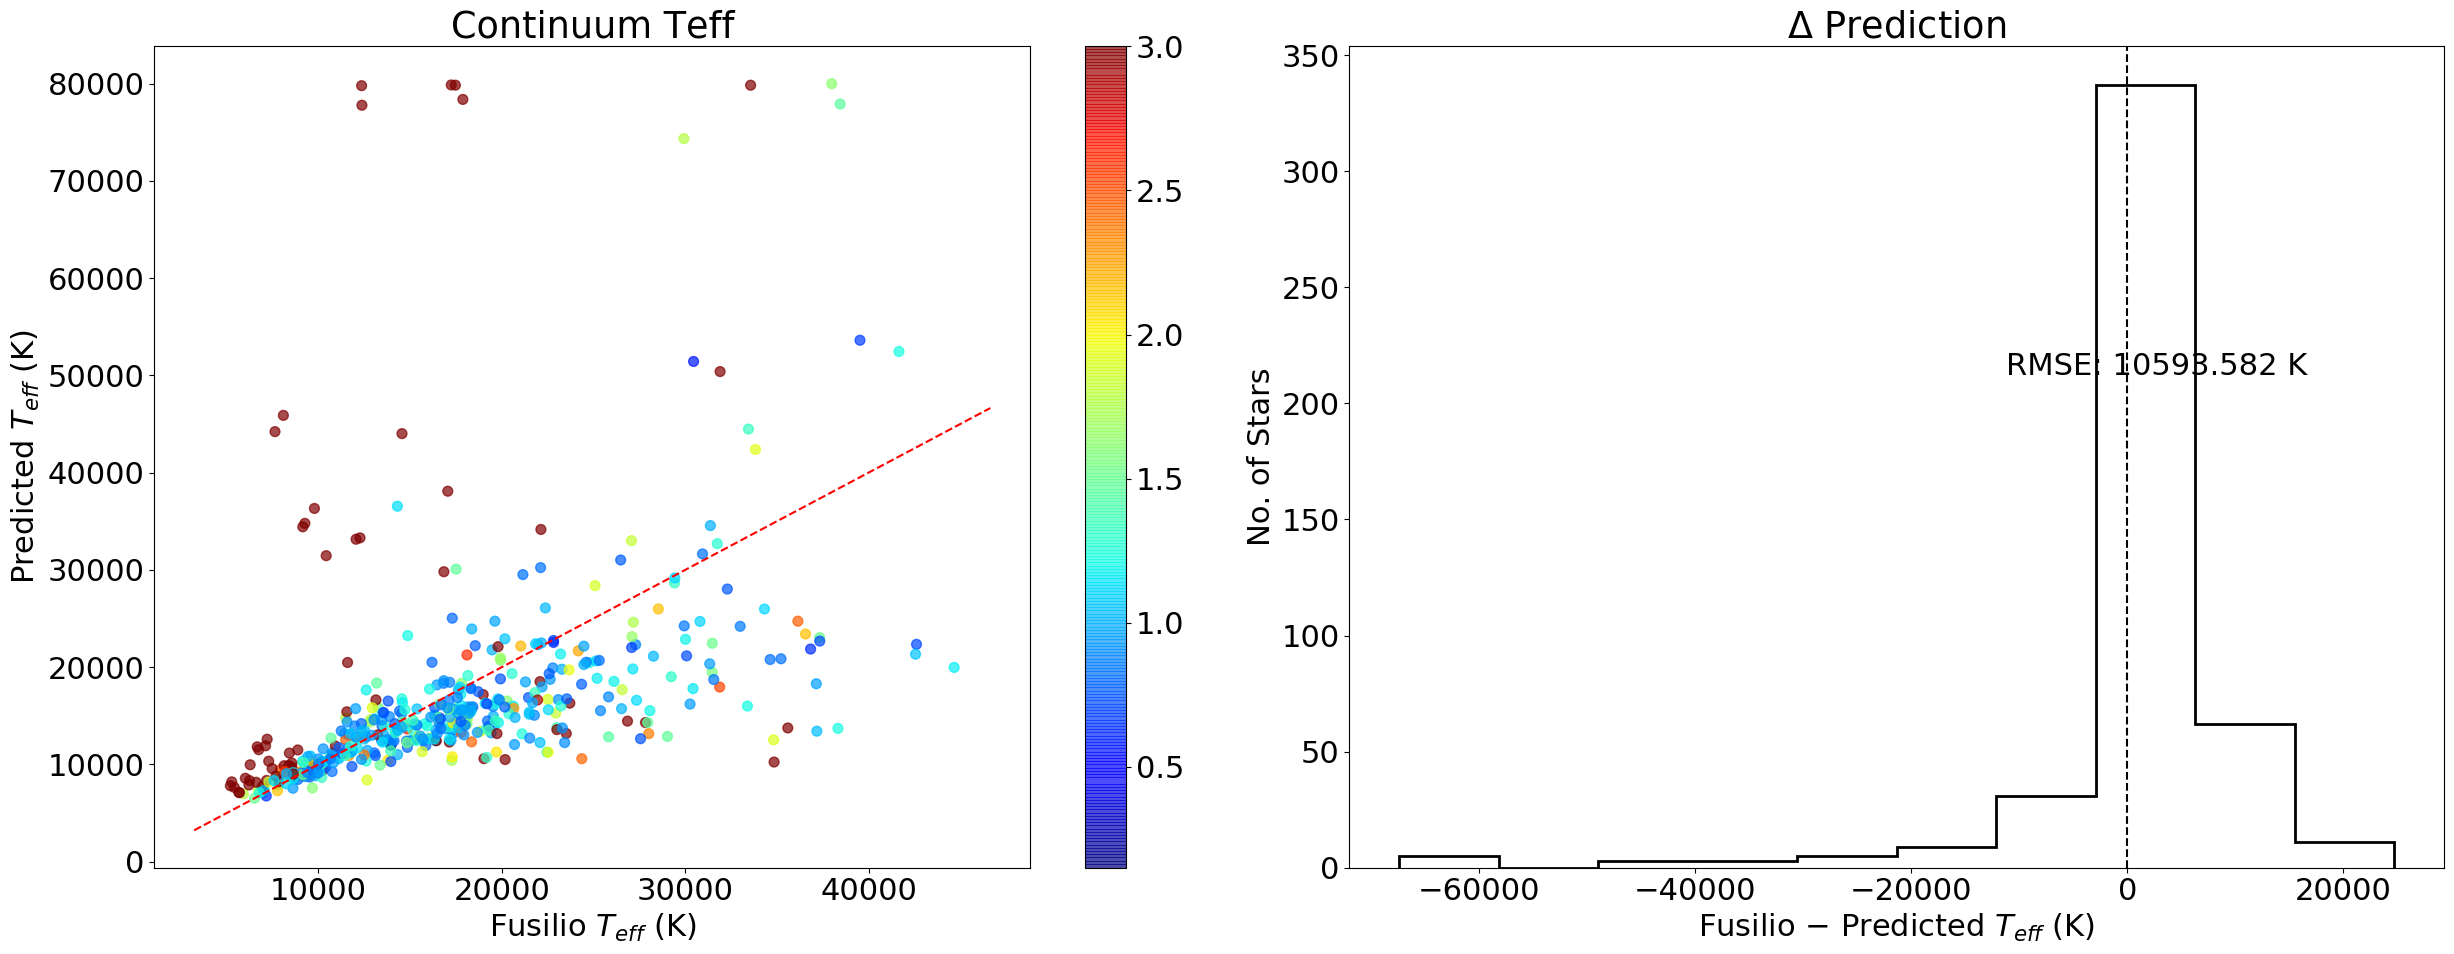

In [52]:
chimask = np.asarray(contchis) < 1000000

plt.style.use('default')
plt.rcParams.update({'font.size': 22})
predictions = teffpredictions[chimask]
y_test = teffreal[chimask]
RMSE = np.sqrt( sum(((y_test-predictions)**2)) / (len(y_test)))
plt.figure(figsize=(25,10))
f=plt.subplot(121)
plt.scatter(y_test,predictions,c=np.asarray(contchis)[chimask],cmap='jet',s=50,alpha=0.7,vmax = 3)
cbar = plt.colorbar()
# plt.errorbar(y_test,predictions,yerr=3*contteffsigs[chimask],linestyle="None",ecolor='k', zorder=1,marker = '.'\
#                     ,markeredgecolor='k',markersize=12,alpha=0.5,mfc='k')
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')

plt.xlabel('Fusilio $T_{eff}$ (K)')
plt.ylabel('Predicted $T_{eff}$ (K)')
plt.title('Continuum Teff')
#plt.ylim(1000,50000)

ax = plt.subplot(122)

plt.hist(y_test-predictions,bins=10,histtype='step',color='k',linewidth = 2);
plt.axvline(x=0,color='k',linestyle='--')
plt.title('$\Delta$ Prediction')
plt.xlabel('Fusilio $-$ Predicted $T_{eff}$ (K)')
plt.ylabel('No. of Stars');
plt.text(0.6,0.6,'RMSE: %.3f K'%RMSE,transform=ax.transAxes)
plt.tight_layout()

print('RMSE: %.3f'%RMSE)

print('Error < 1000 Kelvin: %.2f percent of the time.'\
%(100-(sum(abs(y_test-predictions)>1000))*100/len(y_test)))

RMSE: 12040.427
Error < 1000 Kelvin: 30.84 percent of the time.


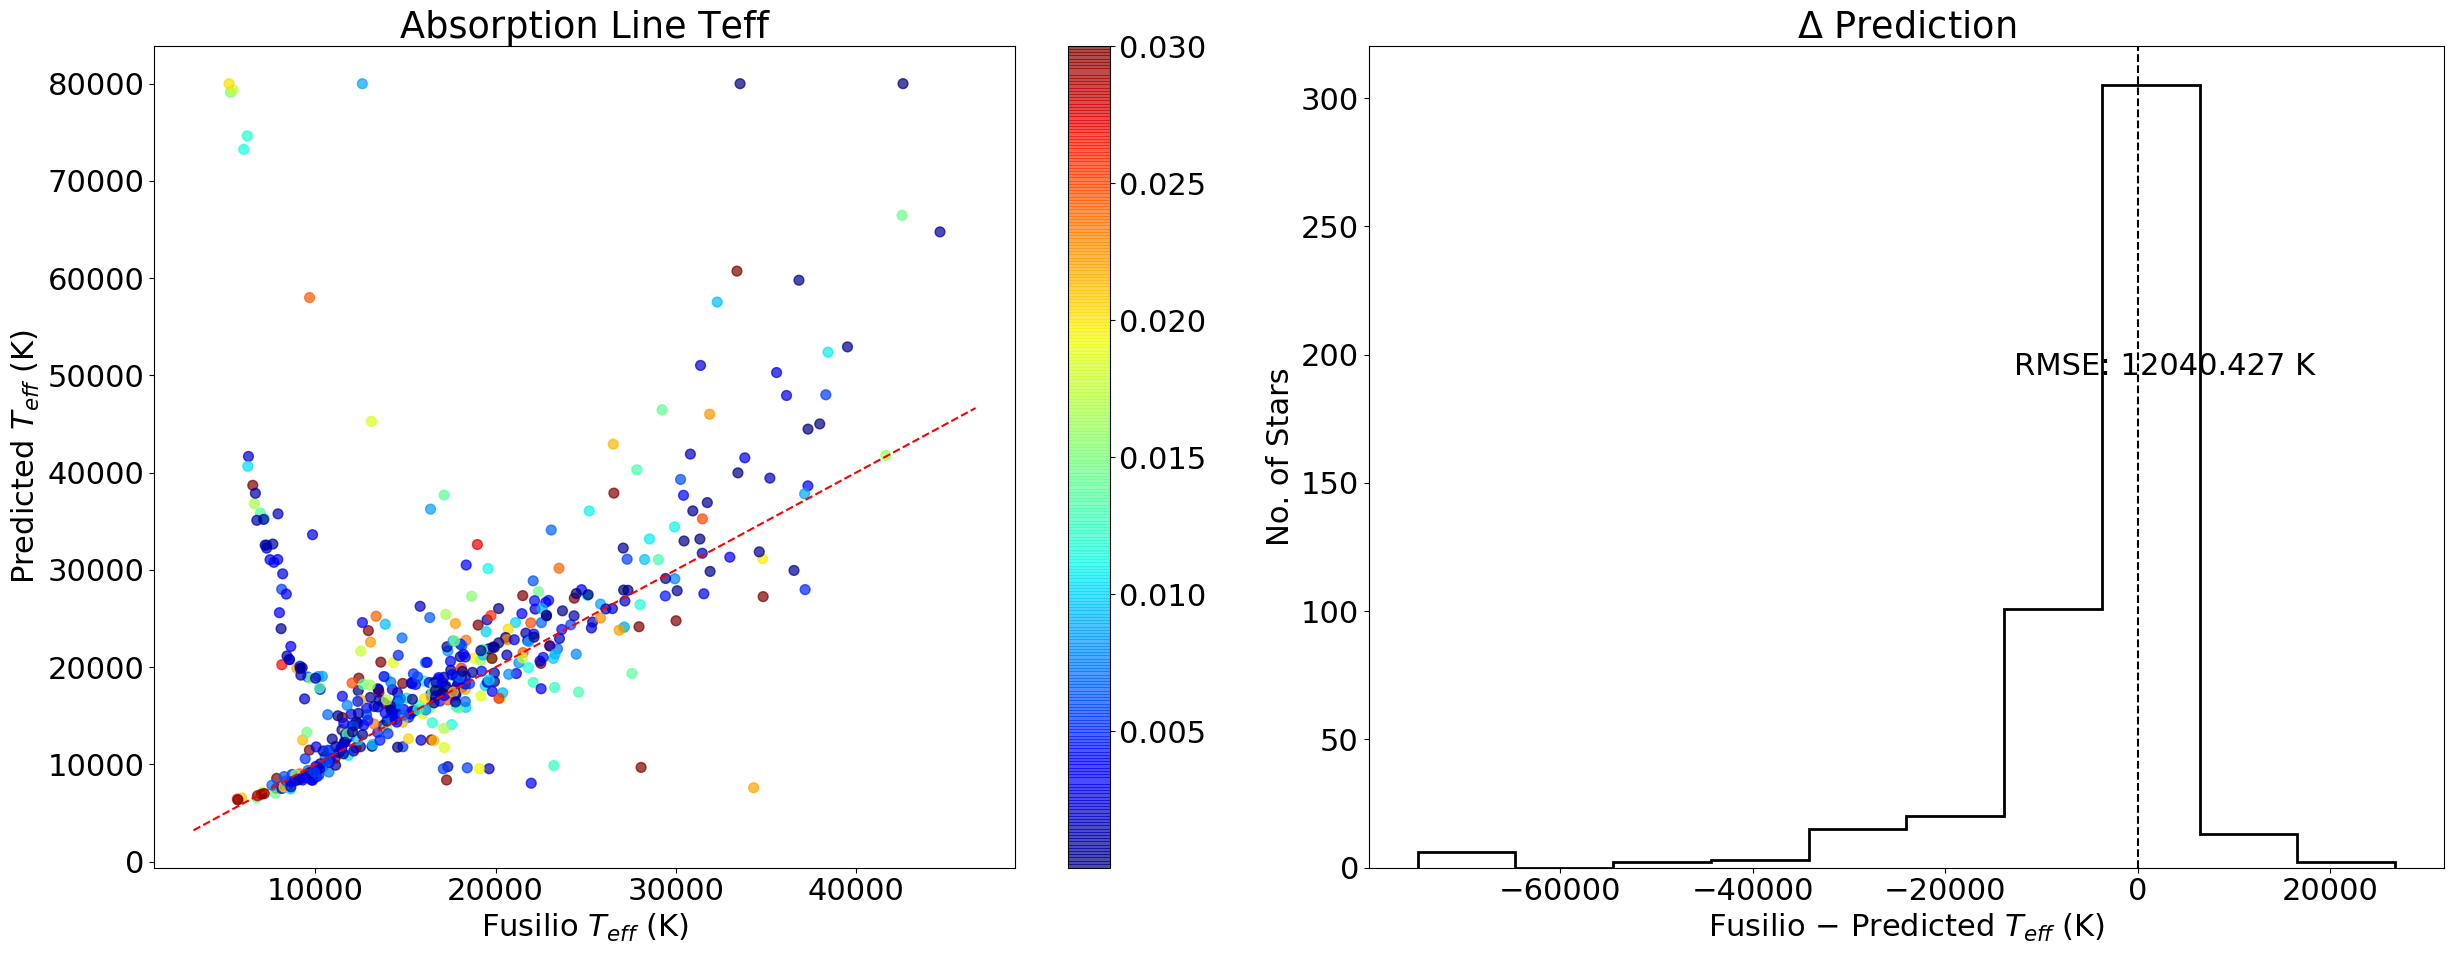

In [59]:
predictions = lineteffs
y_test = teffreal
RMSE = np.sqrt( sum(((y_test-predictions)**2)) / (len(y_test)))
plt.figure(figsize=(25,10))
f=plt.subplot(121)
#plt.errorbar(y_test,predictions,yerr=3*lineteffsigs,linestyle="None",ecolor='k', zorder=1,marker = '.'\
#                     ,markeredgecolor='k',markersize=12,alpha=0.5,mfc='k')
plt.scatter(y_test,predictions,c=np.asarray(linechis),cmap='jet',s=50,alpha=0.7,vmax = 0.03)
c = plt.colorbar()
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.xlabel('Fusilio $T_{eff}$ (K)')
plt.ylabel('Predicted $T_{eff}$ (K)')
plt.title('Absorption Line Teff')
#plt.ylim(1000,50000)
ax = plt.subplot(122)

plt.hist(y_test-predictions,bins=10,histtype='step',color='k',linewidth = 2);
plt.axvline(x=0,color='k',linestyle='--')
plt.title('$\Delta$ Prediction')
plt.xlabel('Fusilio $-$ Predicted $T_{eff}$ (K)')
plt.ylabel('No. of Stars');
plt.text(0.6,0.6,'RMSE: %.3f K'%RMSE,transform=ax.transAxes)
plt.tight_layout()

print('RMSE: %.3f'%RMSE)

print('Error < 1000 Kelvin: %.2f percent of the time.'\
%(100-(sum(abs(y_test-predictions)>1000))*100/len(y_test)))

# Bayesian Framework

In [ ]:
for i in tqdm(range(len(spectra[sel1:20]))):
    
    p,cov = curve_fit(quadratic,lam[mask],spectra[i][mask],p0=[-25,1e-2,1e-5,1e-10])
    contcorr = (spectra[i]/quadratic(lam,p[0],p[1],p[2],p[3]))
    loggparams['t'].set(value=teffpredictions[i],vary=True) 
    result = loggfitter.fit(contcorr[lines],loggparams,wl=lam[lines],method='emcee',nan_policy='omit',\
                        fit_kws = {'steps':1000,'nwalkers':100,'workers':1,'burn':100,'is_weighted':False})

#    result = loggfitter.fit(contcorr[lines],loggparams,wl=lam[lines],method='powell',nan_policy='omit')
        
    lpred = result.params['l'].value
    tpred2 = result.params['t'].value
#     linechis.append(chisquare(result.residual))
    
    plt.figure(figsize=(10,7))
    plt.title('%i K, %.2f dex'%(result.params['t'],result.params['l']))
    plt.plot(lam[lines],contcorr[lines],'k.')
    plt.plot(lam[lines],continuum_gen_sampler(None,teffpredictions[i],lpred,1,result.params['trans']),'r.')
    plt.ylabel('Normalized Flux')
    plt.xlabel('Wavelength(A)')
    plt.tight_layout()
    plt.savefig('corner/'+str(i)+'_fit.png')
    plt.close()
    
    f,axs = plt.subplots(2,2,figsize=(10,10))
    corner.corner(result.flatchain[['t','l']], bins = 15,smooth = 1, range = ((tpred2-5000,tpred2+5000),(6.5,9.5)),\
                 labels = ['$T_{eff}$','$\log{g}$'],fig=f,truths=[tpred2,lpred],show_titles='True')
    #f.suptitle('Spectrum '+str(specnames[i][:-5]+' - (%i K, %.2f dex)'%(TeffHs[i],loggHs[i])),fontsize=18)
    plt.savefig('corner/'+str(i)+'.pdf')
    plt.close()
    
    pickle.dump(result.flatchain,open('flatchain_'+specname+'.p','wb'))







  0%|          | 0/20 [00:00<?, ?it/s]





  5%|▌         | 1/20 [08:17<2:37:28, 497.31s/it]





 10%|█         | 2/20 [16:38<2:29:34, 498.59s/it]





 15%|█▌        | 3/20 [24:59<2:21:26, 499.18s/it]





 20%|██        | 4/20 [33:24<2:13:34, 500.92s/it]





 25%|██▌       | 5/20 [41:29<2:04:00, 496.02s/it]





 30%|███       | 6/20 [49:41<1:55:29, 494.99s/it]





 35%|███▌      | 7/20 [57:59<1:47:24, 495.73s/it]





 40%|████      | 8/20 [1:06:15<1:39:10, 495.85s/it]





 45%|████▌     | 9/20 [1:14:31<1:30:57, 496.14s/it]





 50%|█████     | 10/20 [1:22:43<1:22:26, 494.65s/it]





 55%|█████▌    | 11/20 [1:30:48<1:13:46, 491.81s/it]





 60%|██████    | 12/20 [1:39:06<1:05:50, 493.86s/it]





 65%|██████▌   | 13/20 [1:47:21<57:39, 494.15s/it]  





 70%|███████   | 14/20 [1:55:25<49:05, 490.97s/it]





 75%|███████▌  | 15/20 [2:03:38<40:57, 491.49s/it]